# <a id='toc1_'></a>[Spaceship Titanic](#toc0_)

## <a id='toc1_1_'></a>[Description](#toc0_)

In this competition task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## <a id='toc1_2_'></a>[File and Data Field Descriptions](#toc0_)
**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.


* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

**sample_submission.csv** - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

**Table of contents**<a id='toc0_'></a>    

- [Description](#toc1_1_)    
- [File and Data Field Descriptions](#toc1_2_)    
- [Goal](#toc1_3_)    
- [Objectives](#toc1_4_)    
- [Modeling and Evaluation](#toc1_5_)    
  - [Apply different ensemble methods to predict whether a passenger was transported to alternate dimension.](#toc1_5_1_)    
  - [Ensemble model tuning](#toc1_5_2_)    
    - [Tuning using Optuna](#toc1_5_2_1_)    
    - [Optimize models with AutoML](#toc1_5_2_2_)    
    - [Optimize threshold values](#toc1_5_2_3_)    
  - [Identify the most important features for model predictions.](#toc1_5_3_)    
  - [Predict test set](#toc1_5_4_)    
- [Conclusions](#toc1_6_)    
- [Suggestions for further improvement](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_3_'></a>[Goal](#toc0_)

* Make a model that predicts, whether a passenger was transported to an alternate dimension and to find the features that are the most important for this prediction

## <a id='toc1_4_'></a>[Objectives](#toc0_)

**Modeling and Evaluation**
* Apply different ensemble methods to predict whether a passenger was transported to alternate dimension.
* Tune the models to find the best hyperaparameters.
* Identify the most important features for model predictions.

In [1]:
import sys
import os

project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
utils_dir = os.path.join(project_dir, 'utils')
sys.path.append(utils_dir)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import warnings

import functions as fu
import plotters as pl
import transformers

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
AdaBoostClassifier)
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
import shap
from tpot import TPOTClassifier

c:\Users\jonas\anaconda3\envs\turing\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [3]:
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'font.size': 10, 
    'font.family': 'sans-serif',
    'axes.labelsize': 10,             
    'axes.titlesize': 11,             
    'xtick.labelsize': 8,            
    'ytick.labelsize': 8,            
    'legend.fontsize': 8,            
    'lines.linewidth': 2,             
    'axes.grid': False, 
    })

pastel_blue_green_palette = (
    sns.color_palette(
        [
            "#a6c8e0", "#7fc98f", "#5fc8af", 
            "#9edbad", "#8fa9c7", "#7fbfbf",
            "#578dab", "#4a9a7e"
        ])
)
sequential_palette8 = sns.color_palette(
    [
        '#a7ceef', '#92bcd9', '#7daac3', 
        '#6999ad', '#548799', '#3f7583',
        '#2a5c6d', '#154e5a'
    ]
)

plt.style.use('seaborn-v0_8-muted')
sns.set_palette(pastel_blue_green_palette)


**Split dataset into train and validation**

In [4]:
train = pd.read_csv('../data/train.csv')

In [5]:
X = train.drop('Transported', axis=1)
y = train['Transported']

In [6]:
X_train, X_val, y_train, y_val = (
    train_test_split(X, y, shuffle=True, stratify=y, 
                     test_size=0.2, random_state=1)
)
X_train.to_csv('../data/x_train.csv', index=False)
X_val.to_csv('../data/x_val.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_val.to_csv('../data/y_val.csv', index=False)

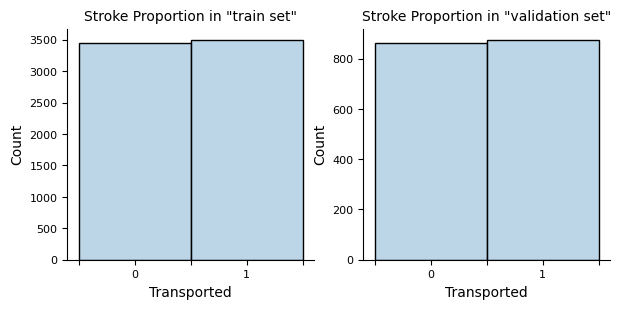

In [7]:
fig, ax = pl.initiate_plot(1, 2, figsize=(7, 3))

y_set_dict = {'train set': y_train, 
              'validation set': y_val}

for i, (label, table) in enumerate(y_set_dict.items()):
    sns.histplot(data=table, discrete=True, ax=ax[i])
    ax[i].set_xticklabels(['','',  0, '', 1])

    ax[i].set_title(f'Stroke Proportion in "{label}"', size='medium')

In [8]:
# Calculate proportion of 'transported' passengers to another dimension
y_train.sum()/y_train.shape[0]

0.5035950532067874

*Comments:*
* For further data analysis, dataset has been split into train and validation. In both split datasets proportion of transported/not-transported passengers kept the same and was 0.5036, so a little more passengers were transported to another dimension.


**Import preprocessed dataset**

Data processing was prepared based on findings in the EDA part. Preprocessing was done in data_preprocess.py.

In [9]:
processed_x_train_data = pd.read_csv('../data/processed_x_train_data.csv')
processed_x_val_data = pd.read_csv('../data/processed_x_val_data.csv')

In [10]:
y_train_data = pd.read_csv('../data/y_train.csv')
y_val_data = pd.read_csv('../data/y_val.csv')

In [11]:
# Before applying modeling, additional feature of clusters is added.
clusterer = transformers.DBSCANTransformer(eps=1, min_samples=20)

In [12]:
processed_x_train_data = clusterer.fit_transform(processed_x_train_data)
processed_x_val_data = clusterer.transform(processed_x_val_data)

---
## <a id='toc1_5_'></a>[Modeling and Evaluation](#toc0_)

The main task of the modeling part is to get the best possible model to determine if a certain passenger has been transported to the other dimension or not. As the dataset is balanced, the main criteria for model success will be accuracy.

### <a id='toc1_5_1_'></a>[Apply different ensemble methods to predict whether a passenger was transported to alternate dimension.](#toc0_)

In [13]:
ensemble_models = {
    'XGBClassifier': make_pipeline(XGBClassifier(verbose=0)),
    'LGBMClassifier': make_pipeline(LGBMClassifier(random_state=1, verbose=-1)),
    'RandomForestClassifier': make_pipeline(RandomForestClassifier(random_state=1)),
    'AdaBoostClassifier': make_pipeline(AdaBoostClassifier(random_state=1)),
    'BaggingClassifier': make_pipeline(BaggingClassifier(random_state=1)),
    'CatBoostClassifier': make_pipeline(CatBoostClassifier(random_state=1, verbose=0))
}

In [14]:
model_cache = {}
model_predictions = {}
model_predicted_probabilities = {}
model_params = {}

for model_name, model in ensemble_models.items():
    model.fit(processed_x_train_data, y_train_data)
    model_cache[model_name] = model

    predictions = model.predict(processed_x_val_data)
    model_predictions[model_name] = predictions

    predicted_probabilities = model.predict_proba(processed_x_val_data)[:, 1]
    model_predicted_probabilities[model_name] = predicted_probabilities

    model_params[model] = model.get_params

In [15]:
def show_results(model_predictions: dict):
    model_classification_results = {}

    for model_name, predictions in model_predictions.items():
        report = classification_report(y_val_data, predictions, output_dict=True)['True']
        report['accuracy'] = accuracy_score(y_val_data, predictions)
        model_classification_results[model_name] = report
    
    return pd.DataFrame(model_classification_results).T

In [16]:
show_results(model_predictions)

,precision,recall,f1-score,support,accuracy
XGBClassifier,0.807186,0.769406,0.787843,876.0,0.791259
LGBMClassifier,0.802273,0.805936,0.804100,876.0,0.802185
RandomForestClassifier,0.815440,0.771689,0.792962,876.0,0.797010
AdaBoostClassifier,0.776231,0.827626,0.801105,876.0,0.792984
BaggingClassifier,0.818065,0.723744,0.768019,876.0,0.779758
CatBoostClassifier,0.813137,0.819635,0.816373,876.0,0.814261


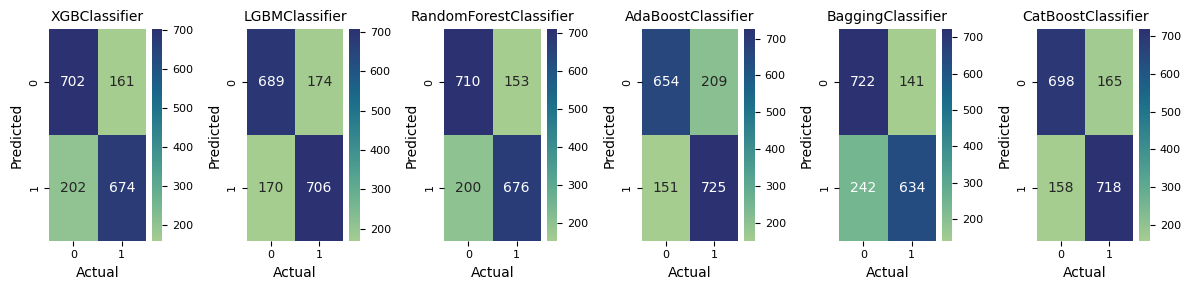

In [20]:
fig, ax = pl.initiate_plot(1, 6, figsize=(12, 3))

for i, (model_name, predictions) in enumerate(model_predictions.items()):
    predictions = predictions.astype(int)
    confusion = confusion_matrix(y_val_data, predictions)
    sns.heatmap(confusion, cmap="crest", annot=True, fmt=".0f", ax=ax[i])
    ax[i].set_title(model_name, size='medium')
    ax[i].set_xlabel("Actual")
    ax[i].set_ylabel("Predicted")

plt.tight_layout()

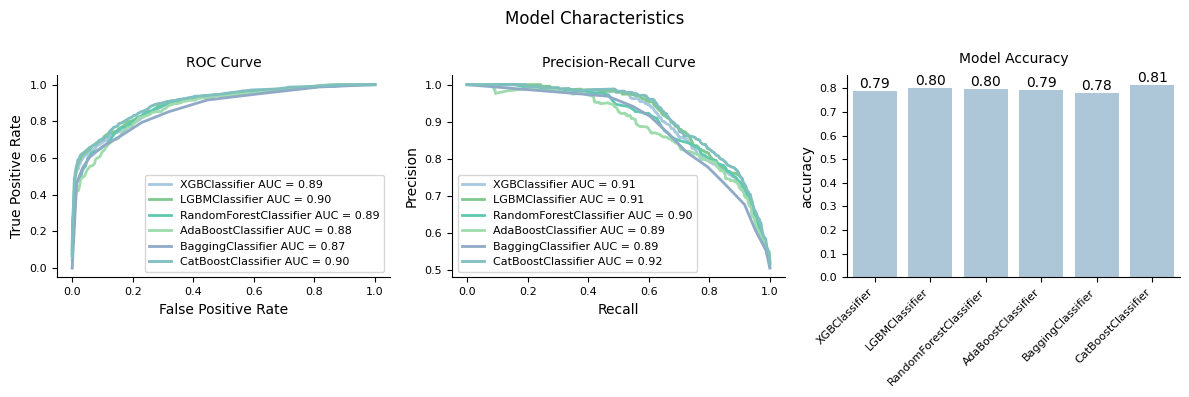

In [19]:
fig, ax = pl.initiate_plot(1, 3, figsize=(12, 4))

results = show_results(model_predictions)

for model_name, pred_proba in model_predicted_probabilities.items():
    pl.plot_roc_curve(y_val_data, pred_proba, model_name, ax=ax[0])
    pl.plot_precision_recall_curve(y_val_data, pred_proba, model_name, ax=ax[1])

sns.barplot(results['accuracy'], ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right');
ax[2].set_title('Model Accuracy', size='medium', y=1.02)

for i, score in enumerate(results['accuracy']):
        ax[2].text(i, score, f"{score:.2f}", ha="center", va="bottom")

plt.suptitle('Model Characteristics')
plt.tight_layout()

*Comments:*
* All ensemble models show similar performance, however, LGBMClassifier and CatBoostClassifier demonstrate a little better accuracy and AUC values. Both false positive and false negative rates are similar.

---
### <a id='toc1_5_2_'></a>[Ensemble model tuning](#toc0_)


#### <a id='toc1_5_2_1_'></a>[Tuning using Optuna](#toc0_)

In [ ]:
# %run optuna_tuning

In [21]:
optuna_best_params = {
 'n_estimators': 463,
 'max_depth': 6,
 'learning_rate': 0.01534842017551196,
 'l2_leaf_reg': 3.89380107574982,
 'border_count': 165, 
 'bagging_temperature': 0.30939430980102606
}

fu.train_and_store_model(optuna_best_params, 
                         'CatBoostClassifier_optuned',
                         CatBoostClassifier,
                         processed_x_train_data, 
                         y_train_data,
                         processed_x_val_data,
                         model_cache,
                         model_predictions,
                         model_predicted_probabilities,
                         model_params)

In [22]:
# Best Optuna LGBMClassifier
optuna_best_params = {
 'n_estimators': 50,
 'max_depth': 15,
 'learning_rate': 0.12133377046662755,
 'num_leaves': 104
}
model_name = 'LGBMClassifier_optuned'

fu.train_and_store_model(optuna_best_params, 
                         model_name,
                         LGBMClassifier,
                         processed_x_train_data, 
                         y_train_data,
                         processed_x_val_data,
                         model_cache,
                         model_predictions,
                         model_predicted_probabilities,
                         model_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [23]:
show_results(model_predictions)

,precision,recall,f1-score,support,accuracy
XGBClassifier,0.807186,0.769406,0.787843,876.0,0.791259
LGBMClassifier,0.802273,0.805936,0.804100,876.0,0.802185
RandomForestClassifier,0.815440,0.771689,0.792962,876.0,0.797010
AdaBoostClassifier,0.776231,0.827626,0.801105,876.0,0.792984
BaggingClassifier,0.818065,0.723744,0.768019,876.0,0.779758
CatBoostClassifier,0.813137,0.819635,0.816373,876.0,0.814261
CatBoostClassifier_optuned,0.799562,0.833333,0.816098,876.0,0.810811
LGBMClassifier_optuned,0.816901,0.794521,0.805556,876.0,0.806786


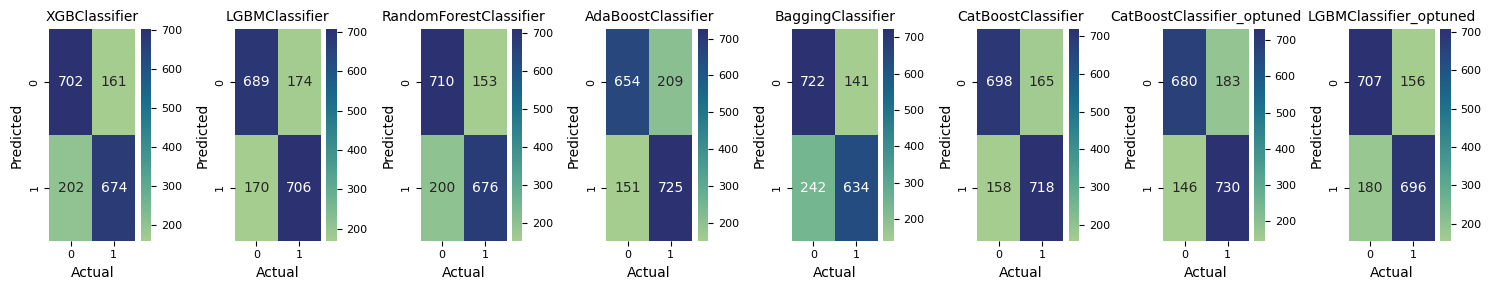

In [25]:
fig, ax = pl.initiate_plot(1, 8, figsize=(15, 3))

for i, (model_name, predictions) in enumerate(model_predictions.items()):
    predictions = predictions.astype(int)
    confusion = confusion_matrix(y_val_data, predictions)
    sns.heatmap(confusion, cmap="crest", annot=True, fmt=".0f", ax=ax[i])
    ax[i].set_title(model_name, size='medium')
    ax[i].set_xlabel("Actual")
    ax[i].set_ylabel("Predicted")

plt.tight_layout()

*Comments:*
* Tuned CatBoostClassifier makes more false negative predictions and less false positive predictions than CatBoostClassifier without tuning.
* Tuned LGBMClassifier better identifies true negatives and worse true positive than LGBMClassifier without tuning. 

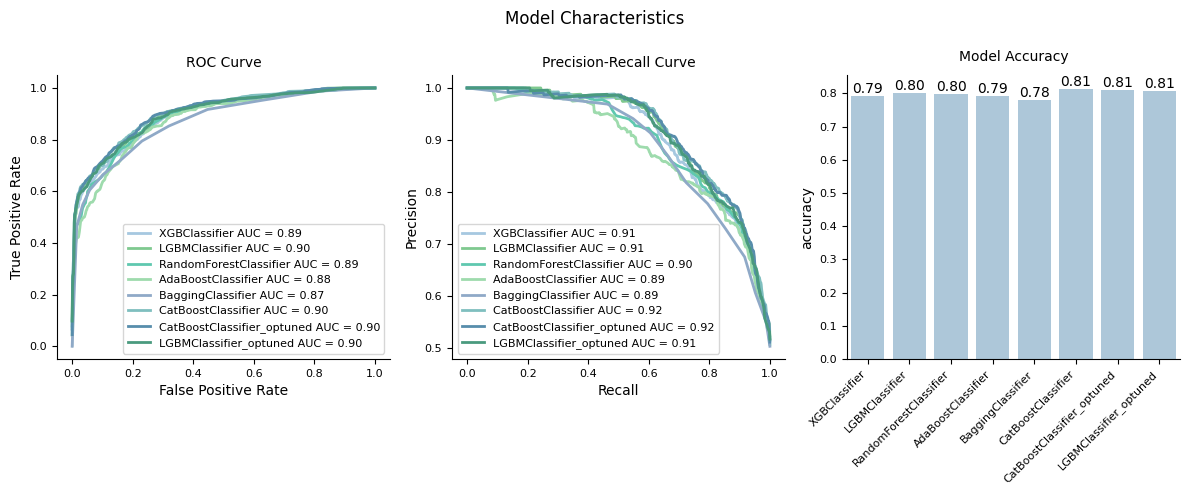

In [ ]:
fig, ax = pl.initiate_plot(1, 3, figsize=(12, 5))

results = show_results(model_predictions)

for model_name, pred_proba in model_predicted_probabilities.items():
    pl.plot_roc_curve(y_val_data, pred_proba, model_name, ax=ax[0])
    pl.plot_precision_recall_curve(y_val_data, pred_proba, model_name, ax=ax[1])

sns.barplot(results['accuracy'], ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right');
ax[2].set_title('Model Accuracy', size='medium', y=1.02)

for i, score in enumerate(results['accuracy']):
        ax[2].text(i, score, f"{score:.2f}", ha="center", va="bottom")

plt.suptitle('Model Characteristics')
plt.tight_layout()

*Comments:*
* Hyperparameter optimization does not show a significant improvement in model accuracy. Optuna'ed models show similar accuracy, ROC AUC and Precision-Recall AUC values. 

---
#### <a id='toc1_5_2_2_'></a>[Optimize models with AutoML](#toc0_)

For automated machine learning model selection, TPOT module will be used. This module optimizes machine learning pipelines using genetic programming and can be used from data cleaning and preprocessing to model selection and parameter selection.

In [ ]:
# model = make_pipeline(TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=1))
# model.fit(processed_x_train_data, y_train_data)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8048605371633677

Generation 2 - Current best internal CV score: 0.8048605371633677

Generation 3 - Current best internal CV score: 0.8048605371633677

Generation 4 - Current best internal CV score: 0.8058669038888228

Generation 5 - Current best internal CV score: 0.8058669038888228

Best pipeline: XGBClassifier(ZeroCount(input_matrix), learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=0.7000000000000001, verbosity=0)


Pipeline(steps=[('tpotclassifier',
                 TPOTClassifier(generations=5, population_size=50,
                                random_state=1, verbosity=2))])

In [27]:
# Best TPOT classifier
tpot_best_params = {
 'learning_rate': 0.1, 
 'max_depth': 4, 
 'min_child_weight': 5, 
 'n_estimators': 100, 
 'n_jobs': -1, 
 'subsample': 0.7000000000000001, 
 'verbosity': 0
}
model_name = 'XGBClassifier_TPOT'

fu.train_and_store_model(tpot_best_params, 
                         model_name,
                         XGBClassifier,
                         processed_x_train_data, 
                         y_train_data,
                         processed_x_val_data,
                         model_cache,
                         model_predictions,
                         model_predicted_probabilities,
                         model_params)

In [28]:
show_results(model_predictions)

,precision,recall,f1-score,support,accuracy
XGBClassifier,0.807186,0.769406,0.787843,876.0,0.791259
LGBMClassifier,0.802273,0.805936,0.804100,876.0,0.802185
RandomForestClassifier,0.815440,0.771689,0.792962,876.0,0.797010
AdaBoostClassifier,0.776231,0.827626,0.801105,876.0,0.792984
BaggingClassifier,0.818065,0.723744,0.768019,876.0,0.779758
CatBoostClassifier,0.813137,0.819635,0.816373,876.0,0.814261
CatBoostClassifier_optuned,0.799562,0.833333,0.816098,876.0,0.810811
LGBMClassifier_optuned,0.816901,0.794521,0.805556,876.0,0.806786
XGBClassifier_TPOT,0.799107,0.817352,0.808126,876.0,0.804485


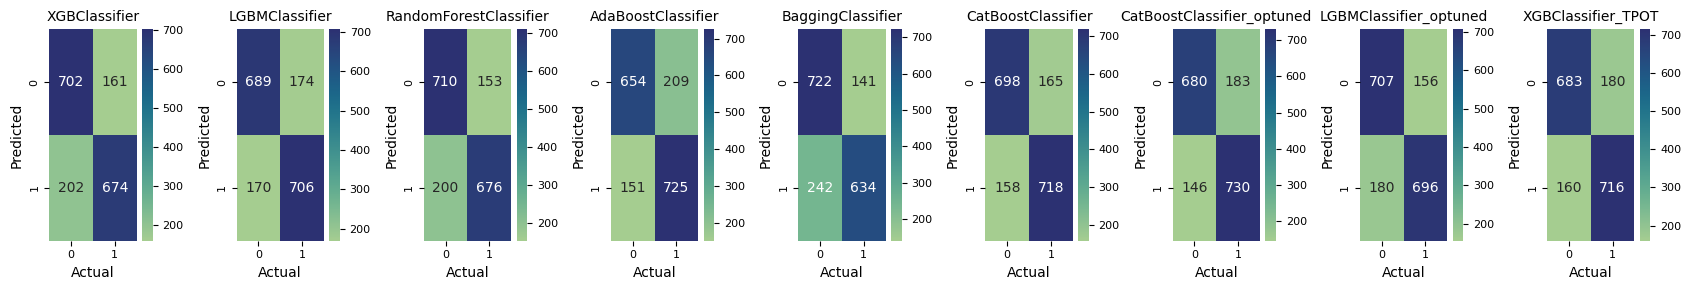

In [29]:
fig, ax = pl.initiate_plot(1, 9, figsize=(17, 3))

for i, (model_name, predictions) in enumerate(model_predictions.items()):
    predictions = predictions.astype(int)
    confusion = confusion_matrix(y_val_data, predictions)
    sns.heatmap(confusion, cmap="crest", annot=True, fmt=".0f", ax=ax[i])
    ax[i].set_title(model_name, size='medium')
    ax[i].set_xlabel("Actual")
    ax[i].set_ylabel("Predicted")

plt.tight_layout()

*Comments:*
* TPOT optimized XGBClassifier model has better true positive rate, but true negative rate is worse. Otherwise, model is comparable to other models.

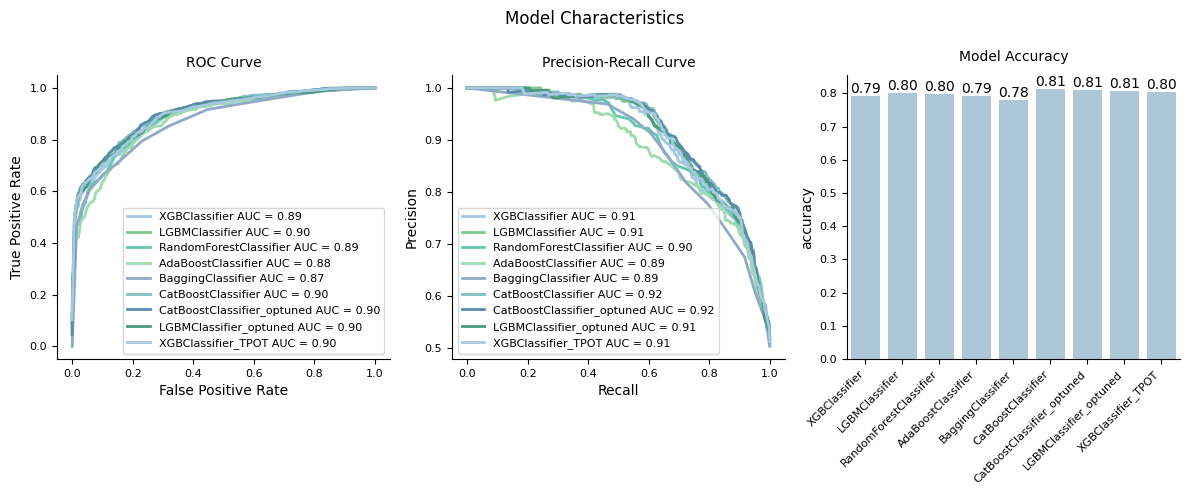

In [ ]:
fig, ax = pl.initiate_plot(1, 3, figsize=(12, 5))

results = show_results(model_predictions)

for model_name, pred_proba in model_predicted_probabilities.items():
    pl.plot_roc_curve(y_val_data, pred_proba, model_name, ax=ax[0])
    pl.plot_precision_recall_curve(y_val_data, pred_proba, model_name, ax=ax[1])

sns.barplot(results['accuracy'], ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right');
ax[2].set_title('Model Accuracy', size='medium', y=1.02)

for i, score in enumerate(results['accuracy']):
        ax[2].text(i, score, f"{score:.2f}", ha="center", va="bottom")

plt.suptitle('Model Characteristics')
plt.tight_layout()

*Comments:*
* TPOT automated machine learning module did not find a better working model than Optuna, however, it's model is based on XGBClassifier and not LGBMClassifier/CatBoostClassifier. The model achieves reasonable 0.804 accuracy and ROC AUC of 0.9, Precision-Recall AUC 0.91.

---
#### <a id='toc1_5_2_3_'></a>[Optimize threshold values](#toc0_)

To predict whether a certain passenger is transported to another dimension or not, a standard threshold of 0.5 is applied. However, this threshold may not always correspond to the goals of identification and may not always be the best threshold. To find the best threshold, optimization will be applied with strategy to find best accuracy.

In [ ]:
# Calculate best threshold and accuracy for each model.
model_accuracy_results = {}

for model_name, predict_proba in model_predicted_probabilities.items():
    best_threshold, best_accuracy = fu.find_best_threshold(y_val, predict_proba)
    predictions = (predict_proba>=best_threshold).astype(int)
    positive_proportion = sum(predictions)/len(predictions)
    model_accuracy_results[model_name] = [best_threshold, best_accuracy, positive_proportion]

In [ ]:
pd.DataFrame(model_accuracy_results, index=['BestThreshold', 'BestAccuracy', 'PositiveProportion']).T

,BestThreshold,BestAccuracy,PositiveProportion
XGBClassifier,0.58,0.798735,0.433583
LGBMClassifier,0.51,0.806786,0.494537
RandomForestClassifier,0.41,0.803335,0.546291
AdaBoostClassifier,0.50,0.792984,0.537090
BaggingClassifier,0.41,0.782059,0.514664
CatBoostClassifier,0.53,0.815411,0.475561
CatBoostClassifier_optuned,0.46,0.814836,0.552041
LGBMClassifier_optuned,0.52,0.810811,0.474411
XGBClassifier_TPOT,0.49,0.805635,0.523289


*Comments:*
* Each classifier achieve the best accuracy at different threshold, some of which even reach 0.58 or 0.41. However, predicted proportion of transported passengers in most cases does not correspond to the initial proportion of the dataset, which is 0.5036. Accuracy for each of the models will be calculated at proportion value of 0.5036.

In [ ]:
# Collect threshold, accuracy and positive proportion results while using selected proportion
model_proportion_results = {}

for model_name, predict_proba in model_predicted_probabilities.items():
    threshold, accuracy = fu.find_proportion_threshold(y_val, predict_proba, proportion=0.5036)
    predictions = (predict_proba>=threshold).astype(int)
    positive_proportion = sum(predictions)/len(predictions)
    model_proportion_results[model_name] = [threshold, accuracy, positive_proportion]

In [ ]:
pd.DataFrame(model_proportion_results, index=['Threshold', 'Accuracy', 'PositiveProportion']).T

,Threshold,Accuracy,PositiveProportion
XGBClassifier,0.4686,0.7936,0.503163
LGBMClassifier,0.5013,0.8028,0.503738
RandomForestClassifier,0.4700,0.7970,0.511213
AdaBoostClassifier,0.5007,0.7936,0.504313
BaggingClassifier,0.5000,0.7798,0.514664
CatBoostClassifier,0.5032,0.8143,0.503163
CatBoostClassifier_optuned,0.5366,0.8108,0.503738
LGBMClassifier_optuned,0.4831,0.8039,0.503738
XGBClassifier_TPOT,0.5124,0.8039,0.503163


*Comments:*
* At selected 0.5036 positive proportion, the best performing models seem to be CatBoostClassifier, CatBoostClassifier_optuned, LGBMClassifier_optuned and XGBClassifier_TPOT. Accuracy of these models has not decreased drastically after changing the threshold from the optimal to a specific. 

---
### <a id='toc1_5_3_'></a>[Identify the most important features for model predictions.](#toc0_)

For identification of the most important parameters, SHAP values will be calculated.

In [ ]:
# Loop over models in model_cache to calculate and store shap values for 
# each model
model_shap_values = {}

for model_name, model in model_cache.items():
    model_shap_values[model_name] = fu.compute_shap(model, model_name, processed_x_train_data)

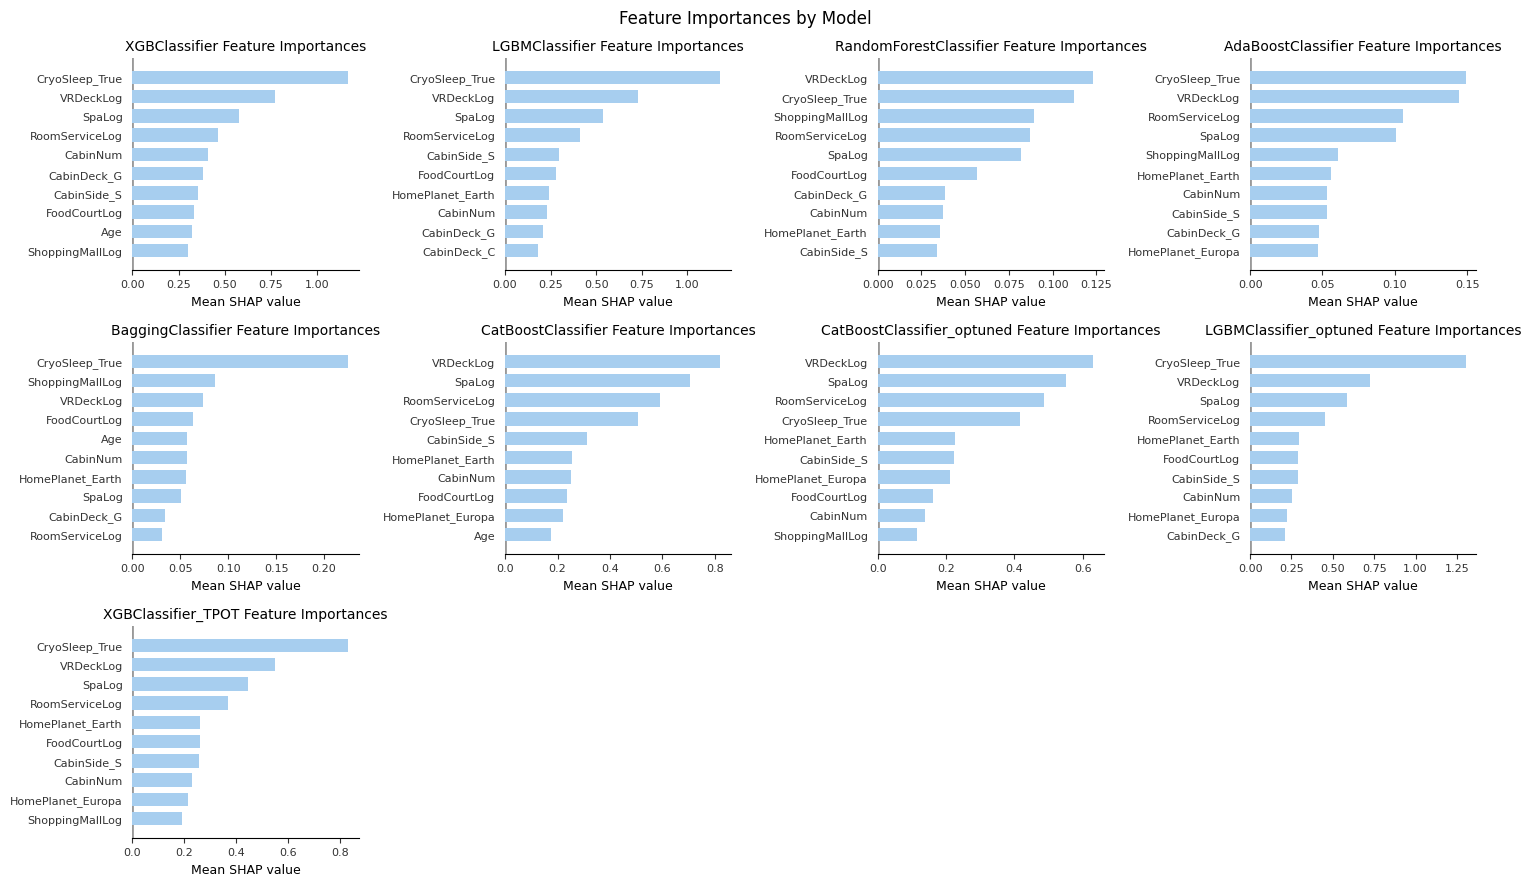

In [ ]:
# Visualize feature importance with shap.summary_plot
X_sample = processed_x_train_data.sample(50, random_state=1)

fig, axes = plt.subplots(3, 4)
axes = axes.flatten()

for i, (model_name, shap_values) in enumerate(model_shap_values.items()):
    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_sample, plot_type='bar', color='#a7ceef', 
                  feature_names=processed_x_train_data.columns, max_display=10, plot_size=(15, 9),
                  show=False)
    axes[i].set_title(f'{model_name} Feature Importances', size='medium')
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel('Mean SHAP value', fontsize=9)

for axes in [axes[-1], axes[-2], axes[-3]]:
    fig.delaxes(axes)
    
plt.suptitle('Feature Importances by Model')
plt.tight_layout()
plt.show()

*Comments:*
* All classifiers identify `CryoSleep` as an important feature, which was seen to have a clear association with beeing transported to another dimension.
* Other features like SpaLog, VRDeckLog, RoomServiceLog which also showed association with transportation to another dimension are also identified as important features.


---
### <a id='toc1_5_4_'></a>[Predict test set](#toc0_)

The best results have been showed by tuned LGBMClassifier and tunned BaggingClassifier. These models will be used to predict test set labels and upload to Kaggle.

In [ ]:
processed_test_data = pd.read_csv('../data/processed_x_test_data.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [ ]:
processed_test_data = clusterer.transform(processed_test_data)
processed_test_data.shape

(4277, 25)

**Cross validation and prediction ensembling**

As predictions from different models may differ, to achieve the best confidence and robustness, best performing models will be used for prediction ensembling.

In [ ]:
best_models = {
    'CatBoostClassifier_optuned': model_cache['CatBoostClassifier_optuned'].named_steps['catboostclassifier'],
    'CatBoostClassifier': model_cache['CatBoostClassifier'].named_steps['catboostclassifier'],
    'LGBMClassifier_optuned': model_cache['LGBMClassifier_optuned'].named_steps['lgbmclassifier'],
    'XGBClassifier_TPOT': model_cache['XGBClassifier_TPOT'].named_steps['xgbclassifier'],
}

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

ensemble_predictions = np.zeros(len(processed_test_data))

n_splits = 10

for model_name, model in best_models.items():
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(processed_x_train_data, y_train_data)):
        X_train, X_val = processed_x_train_data.iloc[train_idx], processed_x_train_data.iloc[val_idx]
        y_train, y_val = y_train_data.iloc[train_idx], y_train_data.iloc[val_idx]

        model.fit(X_train, y_train)
        ensemble_predictions += model.predict_proba(processed_test_data)[:, 1]
        score += model.score(X_val, y_val)

    score = score / n_splits
    print('Model:', model_name)
    print('Average validation acc:', np.round(100 * score, 2))

ensemble_predictions = ensemble_predictions / (n_splits * len(best_models))


Model: CatBoostClassifier_optuned
Average validation acc: 80.63
Model: CatBoostClassifier
Average validation acc: 80.46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

**Calibrate the threshold value to get positive prediction proportion**

In [ ]:
# Initialize threshold and predictions
threshold = 0.1
y_pred = (predicted_probabilities >= threshold).astype(int)

# Adjust the threshold until the proportion condition is met
while sum(y_pred) / len(y_pred) > 0.5036:
    threshold += 0.00005
    y_pred = (predicted_probabilities >= threshold).astype(int)

print('Optimal threshold value is:', threshold)

Optimal threshold value is: 0.5031999999999557


*Comment:*
* According to train set, passengers who were transported make up ~50.36 % of all passengers in the train set. To adjust for that, threshold value closest to train set transported passengers proportion is 0.5032

In [ ]:
ensemble_predictions = (ensemble_predictions>=0.5032).astype(int)

submission_ensemble_predictions = submission.copy()
submission_ensemble_predictions['Transported'] = ensemble_predictions
submission_ensemble_predictions = submission_ensemble_predictions.replace({0: False, 1:True})
submission_ensemble_predictions.to_csv(f'../submissions/submission_ensemble_predictions.csv', index=False)

*Comment:*
* Ensemble prediction Submission results achieved 0.8036.

**Prepare CatBoostClassifier predictions for submission**

In [ ]:
catboost_predictions = (
    model_cache['CatBoostClassifier']
    .named_steps['catboostclassifier']
    .predict_proba(processed_test_data)[:, 1]
)

In [ ]:
# Initialize threshold and predictions
threshold = 0.1
y_pred = (catboost_predictions >= threshold).astype(int)

# Adjust the threshold until the proportion condition is met
while sum(y_pred) / len(y_pred) > 0.5036:
    threshold += 0.00005
    y_pred = (catboost_predictions >= threshold).astype(int)

print('Optimal threshold value is:', threshold)

Optimal threshold value is: 0.49294999999995676


In [ ]:
catboost_predictions = (catboost_predictions>=0.4929).astype(int)

submission_catboost_predictions = submission.copy()
submission_catboost_predictions['Transported'] = catboost_predictions
submission_catboost_predictions = submission_catboost_predictions.replace({0: False, 1:True})
submission_catboost_predictions.to_csv(f'../submissions/submission_catboost.csv', index=False)

*Comment:*
* Catboost Submission results achieved 0.80173.

---
## <a id='toc1_6_'></a>[Conclusions](#toc0_)

* Best modeling results were showed by CatBoostClassifiers and their tuned verions.
* Different optimization methods found different optimal classifiers. The best tuned classifiers were CatBoostClassifier, XGBClassifier and LGBMClassifier.
* Ensemble prediction results achieved overall accuracy pf 0.8036 on test dataset.

## <a id='toc1_7_'></a>[Suggestions for further improvement](#toc0_)

* There are other automated optimization methods like Ray Tune that could be used to find the optimal parameters for modeling.
* EDA part showed that most of the missing values could be imputed based on other column values. A more comprehensive analysis could help find other associations that might help better impute missing values and achieve better model performance. 
* DBSCAN clustering method found ~20 distinct passenger clusters. However, this method does well on data where clusters are dense and separated from one another by less dense data points. Other clustering techniques might improve clustering and find more patterns between passenger groups.